## EVALUACION 4
## JOSE FUENZALIDA

## 1. Importación de Librerías

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

print('✓ Librerías importadas correctamente')
print(f'TensorFlow version: {tf.__version__}')

✓ Librerías importadas correctamente
TensorFlow version: 2.20.0


## 2. Carga de Datos

In [9]:
# Cargar dataset
df = pd.read_csv('data/DATASET_DEFINITIVO.csv')

print('=' * 80)
print('CARGA DEL CONJUNTO DE DATOS')
print('=' * 80)
print(f'Registros: {len(df)}')
print(f'Columnas: {len(df.columns)}')
print(f'\nColumnas disponibles:')
print(df.columns.tolist())
print(f'\nPrimeras 5 filas:')
print(df.head())
print(f'\nInformación del dataset:')
print(df.info())

CARGA DEL CONJUNTO DE DATOS
Registros: 20276
Columnas: 10

Columnas disponibles:
['Region', 'Soil_Type', 'Crop', 'Rainfall_mm', 'Temperature_Celsius', 'Fertilizer_Used', 'Irrigation_Used', 'Weather_Condition', 'Days_to_Harvest', 'Yield_tons_per_hectare']

Primeras 5 filas:
  Region  Soil_Type    Crop  Rainfall_mm  Temperature_Celsius  \
0  Norte     Franco  Cebada   147.998025            29.794042   
1    Sur    Siltoso   Trigo   730.379174            31.620687   
2  Oeste  Arcilloso   Trigo   357.902357            31.593431   
3  Norte    Siltoso   Trigo   181.587861            26.752729   
4  Oeste    Arenoso   Trigo   395.048968            17.646199   

   Fertilizer_Used  Irrigation_Used Weather_Condition  Days_to_Harvest  \
0            False            False           Soleado              106   
1             True             True           Nublado              110   
2            False            False          Lluvioso               90   
3             True            False    

## 3. Preprocesamiento de Datos

In [10]:
# Seleccionar solo columnas numéricas para el autoencoder
# Excluir la columna target (Yield_tons_per_hectare) ya que queremos reconstruir las features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in numeric_cols if col != 'Yield_tons_per_hectare']

print('=' * 80)
print('SELECCIÓN DE CARACTERÍSTICAS')
print('=' * 80)
print(f'Columnas numéricas: {len(numeric_cols)}')
print(f'Características para autoencoder: {len(feature_cols)}')
print(f'Features seleccionadas: {feature_cols}')

# Crear dataframe solo con features
df_autoencoder = df[feature_cols].copy()

# Eliminar valores nulos si existen
df_autoencoder = df_autoencoder.dropna()

print(f'\nDatos después de limpieza: {len(df_autoencoder)} muestras')
print(f'\nEstadísticas descriptivas:')
print(df_autoencoder.describe())

SELECCIÓN DE CARACTERÍSTICAS
Columnas numéricas: 4
Características para autoencoder: 3
Features seleccionadas: ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']

Datos después de limpieza: 20276 muestras

Estadísticas descriptivas:
        Rainfall_mm  Temperature_Celsius  Days_to_Harvest
count  20276.000000         20276.000000     20276.000000
mean     548.117849            27.494618       104.636467
std      259.417991             7.187461        25.895177
min      100.006823            15.000617        60.000000
25%      324.556941            21.273334        82.000000
50%      546.676953            27.513764       104.000000
75%      772.944139            33.705525       127.000000
max      999.954481            39.997214       149.000000


## 4. Normalización de Datos

In [11]:
print('=' * 80)
print('NORMALIZACIÓN DE DATOS')
print('=' * 80)

# Normalización con MinMaxScaler (0-1)
scaler_ae = MinMaxScaler()
data_normalized = scaler_ae.fit_transform(df_autoencoder)

print(f'Rango original: [{df_autoencoder.min().min():.2f}, {df_autoencoder.max().max():.2f}]')
print(f'Rango normalizado: [{data_normalized.min():.2f}, {data_normalized.max():.2f}]')

# División en conjuntos de entrenamiento y prueba
X_train_ae, X_test_ae = train_test_split(data_normalized, test_size=0.2, random_state=42)

print(f'\nConjunto de entrenamiento: {X_train_ae.shape[0]} muestras')
print(f'Conjunto de prueba: {X_test_ae.shape[0]} muestras')
print(f'Dimensión de entrada: {X_train_ae.shape[1]} características')

NORMALIZACIÓN DE DATOS
Rango original: [15.00, 999.95]
Rango normalizado: [0.00, 1.00]

Conjunto de entrenamiento: 16220 muestras
Conjunto de prueba: 4056 muestras
Dimensión de entrada: 3 características


## 5. Arquitectura del Autoencoder

In [12]:
print('=' * 80)
print('DEFINICIÓN DE DIMENSIONES DEL AUTOENCODER')
print('=' * 80)

# Definir dimensiones
input_dim = X_train_ae.shape[1]  # Número de características
latent_dim = 2  # Dimensión del espacio latente (compresión)
encoding_dim_layer1 = 128  # Primer nivel de compresión
encoding_dim_layer2 = 64   # Segundo nivel de compresión

print(f'Dimensión de entrada: {input_dim}')
print(f'Dimensión latente: {latent_dim}')
print(f'Capas ocultas: {encoding_dim_layer1} → {encoding_dim_layer2}')
print(f'Factor de compresión: {input_dim/latent_dim:.1f}x')

DEFINICIÓN DE DIMENSIONES DEL AUTOENCODER
Dimensión de entrada: 3
Dimensión latente: 2
Capas ocultas: 128 → 64
Factor de compresión: 1.5x


## 6. Construcción del Encoder y Decoder

In [13]:
# Input layer
input_layer = layers.Input(shape=(input_dim,), name='input')

# Encoder - Primera capa
encoded_1 = layers.Dense(encoding_dim_layer1, activation='relu', name='encoder_layer_1')(input_layer)
encoded_1 = layers.BatchNormalization(name='encoder_bn_1')(encoded_1)
encoded_1 = layers.Dropout(0.2, name='encoder_dropout_1')(encoded_1)

# Encoder - Segunda capa
encoded_2 = layers.Dense(encoding_dim_layer2, activation='relu', name='encoder_layer_2')(encoded_1)
encoded_2 = layers.BatchNormalization(name='encoder_bn_2')(encoded_2)

# Espacio latente (cuello de botella)
latent_space = layers.Dense(latent_dim, activation='relu', name='latent_space')(encoded_2)

print(f"  Codificador construido:")
print(f"  Input ({input_dim}) → Dense({encoding_dim_layer1}) → BN → Dropout(0.2)")
print(f"  → Dense({encoding_dim_layer2}) → BN → Dense({latent_dim}) [LATENT SPACE]")

# ==================== DECODIFICADOR ====================
print(f" Construyendo DECODIFICADOR (Decoder)...")

# Decoder - Primera capa (simétrica al encoder)
decoded_1 = layers.Dense(encoding_dim_layer2, activation='relu', name='decoder_layer_1')(latent_space)
decoded_1 = layers.BatchNormalization(name='decoder_bn_1')(decoded_1)

# Decoder - Segunda capa
decoded_2 = layers.Dense(encoding_dim_layer1, activation='relu', name='decoder_layer_2')(decoded_1)
decoded_2 = layers.BatchNormalization(name='decoder_bn_2')(decoded_2)
decoded_2 = layers.Dropout(0.2, name='decoder_dropout_1')(decoded_2)

# Output layer - Reconstrucción
output_layer = layers.Dense(input_dim, activation='sigmoid', name='output')(decoded_2)

print(f"  Decodificador construido:")
print(f"  Latent({latent_dim}) → Dense({encoding_dim_layer2}) → BN")
print(f"  → Dense({encoding_dim_layer1}) → BN → Dropout(0.2) → Dense({input_dim}) [OUTPUT]")

I0000 00:00:1764925720.209534   81126 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4548 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


  Codificador construido:
  Input (3) → Dense(128) → BN → Dropout(0.2)
  → Dense(64) → BN → Dense(2) [LATENT SPACE]
 Construyendo DECODIFICADOR (Decoder)...
  Decodificador construido:
  Latent(2) → Dense(64) → BN
  → Dense(128) → BN → Dropout(0.2) → Dense(3) [OUTPUT]


In [14]:
# Crear modelo autoencoder completo
autoencoder = Model(inputs=input_layer, outputs=output_layer, name='Autoencoder')

autoencoder.summary()

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_1 (Dense)         │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn_1                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout_1 (Dropout)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_2 (Dense)         │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn_2                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 2)              │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_layer_1 (Dense)         │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_bn_1                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_layer_2 (Dense)         │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_bn_2                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dropout_1 (Dropout)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,333 (75.52 KB)

 Trainable params: 18,565 (72.52 KB)

 Non-trainable params: 768 (3.00 KB)

In [15]:
# Crear modelo encoder independiente para extraer representaciones latentes
encoder_model = Model(inputs=input_layer, outputs=latent_space, name='Encoder')

print(f" Resumen del Encoder:")
encoder_model.summary()

 Resumen del Encoder:


Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_1 (Dense)         │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn_1                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout_1 (Dropout)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_2 (Dense)         │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn_2                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,666 (37.76 KB)

 Trainable params: 9,282 (36.26 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100


2025-12-05 06:08:42.614488: I external/local_xla/xla/service/service.cc:163] XLA service 0x76d82c003f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-05 06:08:42.614500: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 with Max-Q Design, Compute Capability 7.5
2025-12-05 06:08:42.661931: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-05 06:08:42.961490: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-12-05 06:08:42.961490: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


110/507 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0718 - mae: 0.2098

I0000 00:00:1764925724.629212   81231 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0428 - mae: 0.1617 - val_loss: 0.0269 - val_mae: 0.1293 - learning_rate: 0.0010
Epoch 2/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0428 - mae: 0.1617 - val_loss: 0.0269 - val_mae: 0.1293 - learning_rate: 0.0010
Epoch 2/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0246 - mae: 0.1237 - val_loss: 0.0151 - val_mae: 0.0973 - learning_rate: 0.0010
Epoch 3/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0246 - mae: 0.1237 - val_loss: 0.0151 - val_mae: 0.0973 - learning_rate: 0.0010
Epoch 3/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0199 - mae: 0.1112 - val_loss: 0.0118 - val_mae: 0.0809 - learning_rate: 0.0010
Epoch 4/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0199 - mae: 0.1112 - val_loss: 0.0118 - val_mae: 0.0809 - learning_rate: 0.0010
Epoch 4/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0176 - mae: 0.1047 - val_loss: 0.0117 - val_mae: 0.0837 - learning_rate: 0.0010
Epoch 5/100

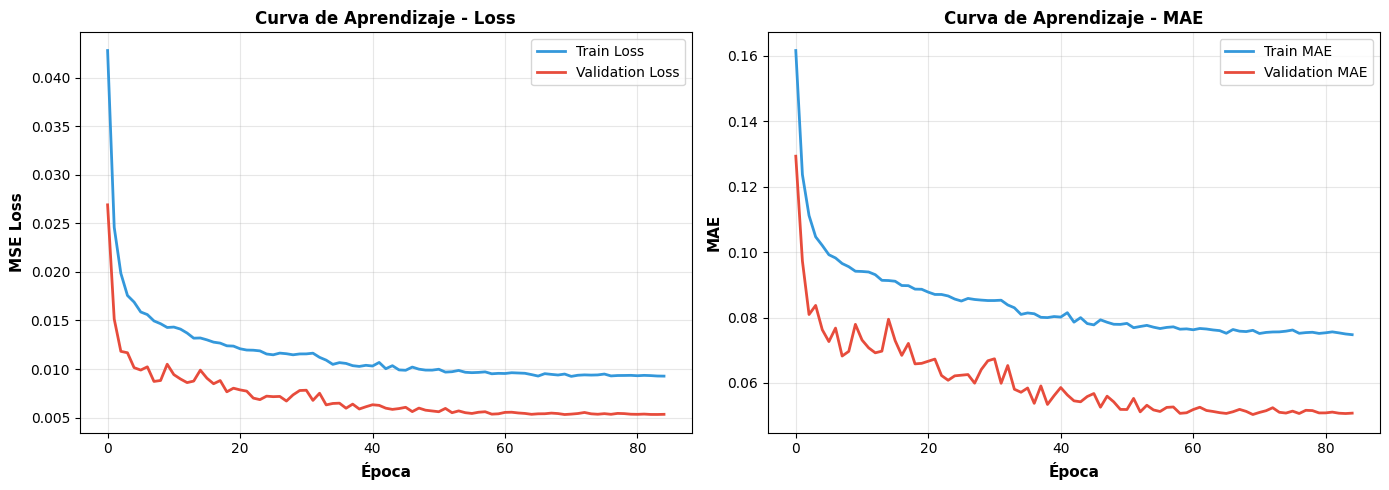

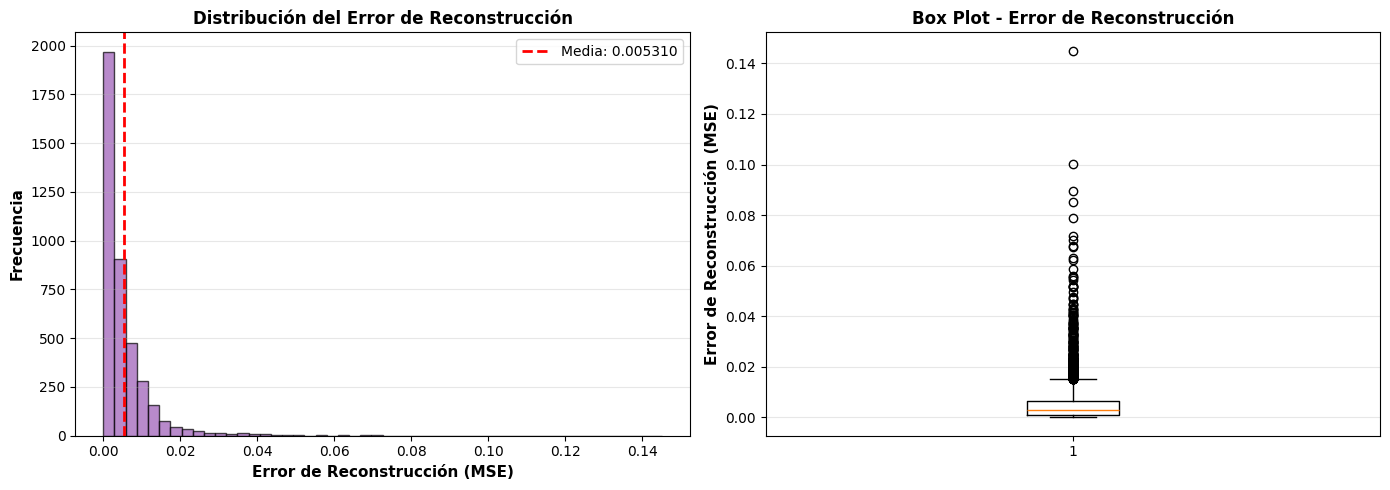

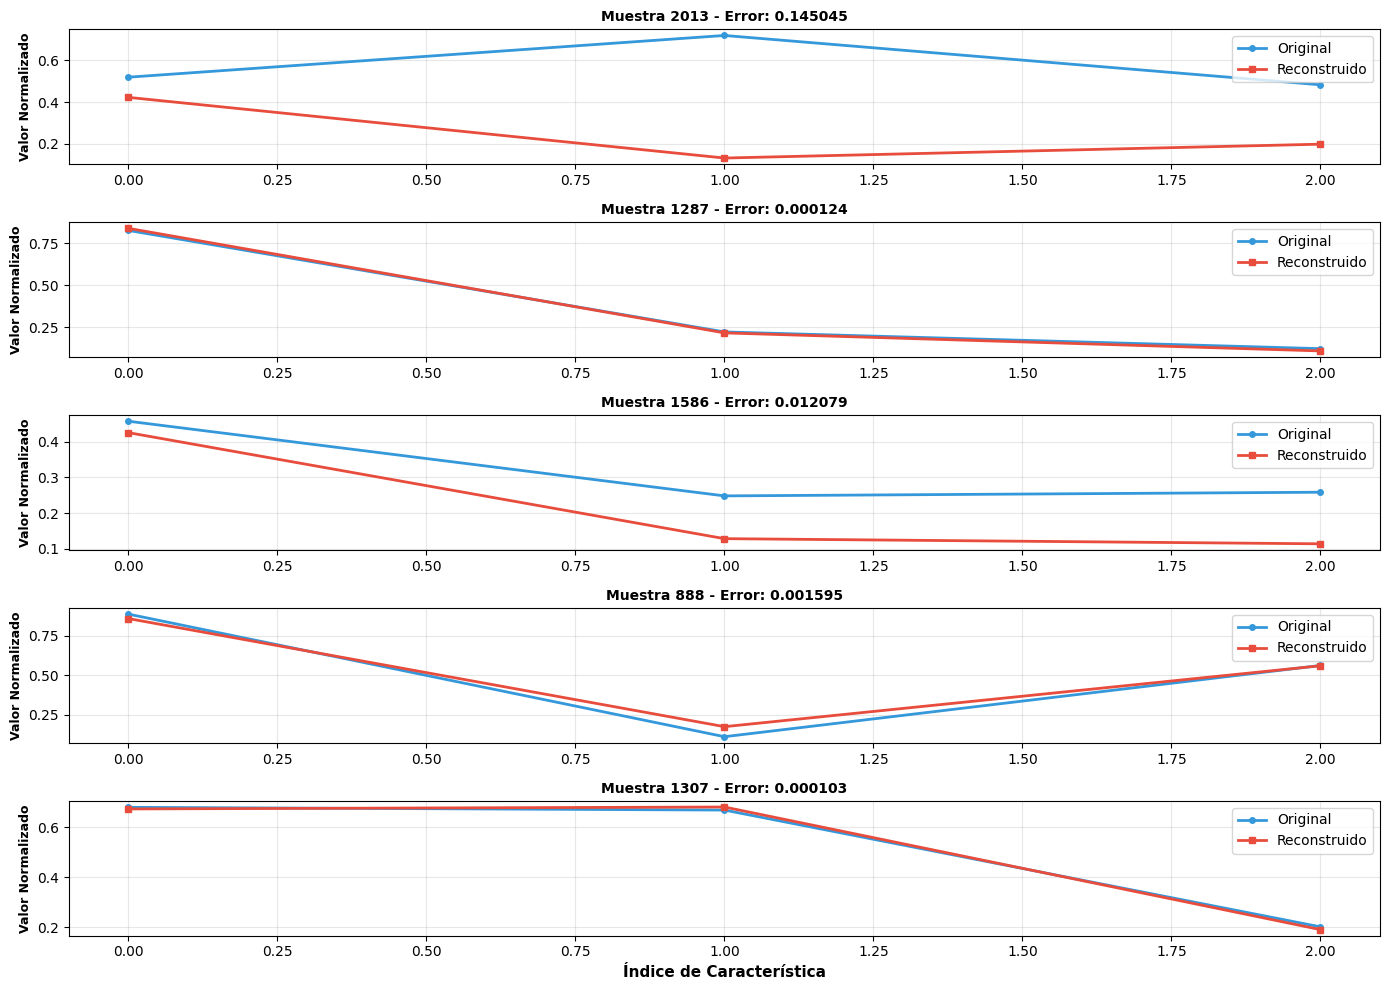

 Visualizando espacio latente...


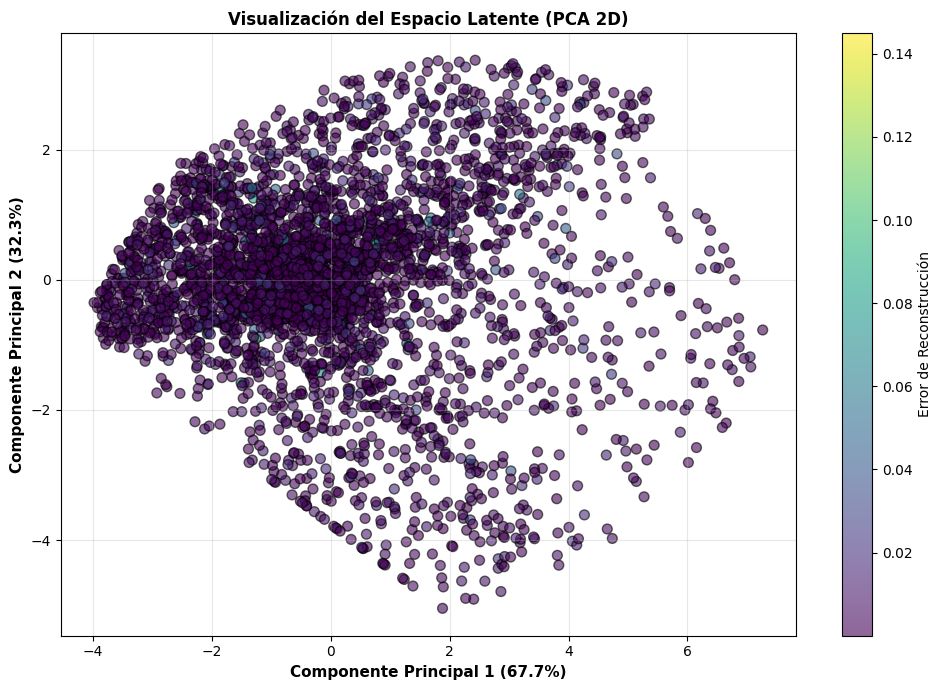

  Análisis de Anomalías:
  Umbral de detección: 0.020920
  Anomalías detectadas: 141 / 4056 (3.48%)
  Muestras normales: 3915
 Top 5 anomalías (mayor error de reconstrucción):
    1. Muestra 2012: Error = 0.145045
    2. Muestra 2752: Error = 0.100028
    3. Muestra 1736: Error = 0.089517
    4. Muestra 637: Error = 0.085180
    5. Muestra 830: Error = 0.078967

RESUMEN FINAL - AUTOENCODER


In [16]:

# ==================== COMPILACIÓN ====================
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',  # Mean Squared Error para reconstrucción
    metrics=['mae']  # Mean Absolute Error como métrica adicional
)
# ==================== ENTRENAMIENTO ====================
# Callbacks para mejor entrenamiento
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Entrenar el autoencoder
history = autoencoder.fit(
    X_train_ae, X_train_ae,  # Input = Output (reconstrucción)
    epochs=100,
    batch_size=32,
    validation_data=(X_test_ae, X_test_ae),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# ==================== EVALUACIÓN ====================
# Evaluar en conjunto de prueba
test_loss, test_mae = autoencoder.evaluate(X_test_ae, X_test_ae, verbose=0)
train_loss, train_mae = autoencoder.evaluate(X_train_ae, X_train_ae, verbose=0)

print(f"  MÉTRICAS DE RENDIMIENTO:")
print(f"  ENTRENAMIENTO:")
print(f"  MSE Loss: {train_loss:.6f}")
print(f"  MAE: {train_mae:.6f}")
print(f"  PRUEBA:")
print(f"  MSE Loss: {test_loss:.6f}")
print(f"  MAE: {test_mae:.6f}")
print(f"  GENERALIZACIÓN:")
# Calcular diferencia absoluta
diff_loss = float(train_loss) - float(test_loss)
if diff_loss < 0:
    diff_loss = -diff_loss
print(f"  Diferencia Loss: {diff_loss:.6f}")

# Generar predicciones (reconstrucciones)
X_test_reconstructed = autoencoder.predict(X_test_ae, verbose=0)

# Calcular error de reconstrucción por muestra
reconstruction_error = np.mean(np.square(X_test_ae - X_test_reconstructed), axis=1)

print(f"  ERROR DE RECONSTRUCCIÓN:")
print(f"  Media: {np.mean(reconstruction_error):.6f}")
print(f"  Desviación estándar: {np.std(reconstruction_error):.6f}")
print(f"  Min: {np.min(reconstruction_error):.6f}")
print(f"  Max: {np.max(reconstruction_error):.6f}")

# ==================== VISUALIZACIONES ====================
# 1. Historial de entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', color='#3498db', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='#e74c3c', linewidth=2)
axes[0].set_xlabel('Época', fontsize=11, fontweight='bold')
axes[0].set_ylabel('MSE Loss', fontsize=11, fontweight='bold')
axes[0].set_title('Curva de Aprendizaje - Loss', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE', color='#3498db', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', color='#e74c3c', linewidth=2)
axes[1].set_xlabel('Época', fontsize=11, fontweight='bold')
axes[1].set_ylabel('MAE', fontsize=11, fontweight='bold')
axes[1].set_title('Curva de Aprendizaje - MAE', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Distribución del error de reconstrucción
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(reconstruction_error, bins=50, color='#9b59b6', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(reconstruction_error), color='r', linestyle='--', linewidth=2,
                label=f'Media: {np.mean(reconstruction_error):.6f}')
axes[0].set_xlabel('Error de Reconstrucción (MSE)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
axes[0].set_title('Distribución del Error de Reconstrucción', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Box plot
axes[1].boxplot(reconstruction_error, vert=True)
axes[1].set_ylabel('Error de Reconstrucción (MSE)', fontsize=11, fontweight='bold')
axes[1].set_title('Box Plot - Error de Reconstrucción', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Comparación Original vs Reconstruido (primeras 5 muestras)
n_samples = 5
sample_indices = np.random.choice(len(X_test_ae), n_samples, replace=False)

fig, axes = plt.subplots(n_samples, 1, figsize=(14, 10))

for idx, sample_idx in enumerate(sample_indices):
    original = X_test_ae[sample_idx]
    reconstructed = X_test_reconstructed[sample_idx]

    x_pos = np.arange(len(original))
    axes[idx].plot(x_pos, original, 'o-', label='Original', color='#3498db', linewidth=2, markersize=4)
    axes[idx].plot(x_pos, reconstructed, 's-', label='Reconstruido', color='#e74c3c', linewidth=2, markersize=4)
    axes[idx].set_ylabel('Valor Normalizado', fontsize=9, fontweight='bold')
    axes[idx].set_title(f'Muestra {sample_idx + 1} - Error: {reconstruction_error[sample_idx]:.6f}',
                        fontsize=10, fontweight='bold')
    axes[idx].legend(loc='upper right')
    axes[idx].grid(alpha=0.3)

axes[-1].set_xlabel('Índice de Característica', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

# 4. Visualización del espacio latente (usando PCA para 2D)
print(" Visualizando espacio latente...")
latent_representations = encoder_model.predict(X_test_ae, verbose=0)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_representations)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1],
                     c=reconstruction_error,
                     cmap='viridis',
                     alpha=0.6,
                     s=50,
                     edgecolors='black')
plt.colorbar(scatter, label='Error de Reconstrucción')
plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
          fontsize=11, fontweight='bold')
plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)',
          fontsize=11, fontweight='bold')
plt.title('Visualización del Espacio Latente (PCA 2D)', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ==================== DETECCIÓN DE ANOMALÍAS ====================
# Definir umbral de anomalía (mean + 2*std)
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)
anomalies = reconstruction_error > threshold
n_anomalies = np.sum(anomalies)

print(f"  Análisis de Anomalías:")
print(f"  Umbral de detección: {threshold:.6f}")
print(f"  Anomalías detectadas: {n_anomalies} / {len(X_test_ae)} ({n_anomalies/len(X_test_ae)*100:.2f}%)")
print(f"  Muestras normales: {len(X_test_ae) - n_anomalies}")

if n_anomalies > 0:
    print(f" Top 5 anomalías (mayor error de reconstrucción):")
    top_anomaly_indices = np.argsort(reconstruction_error)[-5:][::-1]
    for i, idx in enumerate(top_anomaly_indices, 1):
        print(f"    {i}. Muestra {idx}: Error = {reconstruction_error[idx]:.6f}")

# ==================== RESUMEN FINAL ====================
print("\n" + "=" * 80)
print("RESUMEN FINAL - AUTOENCODER")
print("=" * 80)

RESUMEN_AUTOENCODER = f"""
IMPLEMENTACIÓN COMPLETADA
ESPECIFICACIONES DEL MODELO:
  Tipo: Autoencoder Profundo (Deep Autoencoder)
  Framework: TensorFlow/Keras
  Arquitectura: {input_dim} → {encoding_dim_layer1} → {encoding_dim_layer2} → {latent_dim} → {encoding_dim_layer2} → {encoding_dim_layer1} → {input_dim}
  Factor de compresión: {input_dim / latent_dim:.2f}x
  Parámetros totales: {autoencoder.count_params():,}

DATOS PROCESADOS:
  Total de muestras: {len(data_normalized)}
  Características de entrada: {input_dim}
  Train: {len(X_train_ae)} muestras (80%)
  Test: {len(X_test_ae)} muestras (20%)
  Normalización: MinMaxScaler [0, 1]

ENTRENAMIENTO:
  Épocas ejecutadas: {len(history.history['loss'])}
  Batch size: 32
  Optimizer: Adam (lr=0.001)
  Loss function: MSE
  Callbacks: EarlyStopping, ReduceLROnPlateau

RESULTADOS:
  Train Loss (MSE): {train_loss:.6f}
  Test Loss (MSE): {test_loss:.6f}
  Test MAE: {test_mae:.6f}
  Generalización: {'✓ Buena' if diff_loss < 0.01 else '⚠ Regular'}

DETECCIÓN DE ANOMALÍAS:
  Umbral: {threshold:.6f}
  Anomalías: {n_anomalies} ({n_anomalies/len(X_test_ae)*100:.2f}%)
  Muestras normales: {len(X_test_ae) - n_anomalies}

APLICACIONES:
  Reducción de dimensionalidad ({input_dim}D → {latent_dim}D)
  Detección de anomalías en producción agrícola
  Extracción de características latentes
  Compresión de datos para almacenamiento eficiente
  Preprocesamiento para otros modelos ML

════════════════════════════════════════════════════════════════
"""

## 7. MLOPS - MONITOREO Y VERSIONAMIENTO

Implementacion de practicas MLOps para garantizar reproducibilidad y trazabilidad del modelo.

Configuracion del Sistema de Tracking

In [17]:
import os
import json
import hashlib
from datetime import datetime
import pickle

# Crear directorios para MLOps
os.makedirs('mlops_tracking', exist_ok=True)
os.makedirs('mlops_tracking/models', exist_ok=True)
os.makedirs('mlops_tracking/datasets', exist_ok=True)
os.makedirs('mlops_tracking/metrics', exist_ok=True)
os.makedirs('mlops_tracking/logs', exist_ok=True)

print('Directorios de tracking creados:')
print('  - mlops_tracking/models/')
print('  - mlops_tracking/datasets/')
print('  - mlops_tracking/metrics/')
print('  - mlops_tracking/logs/')

Directorios de tracking creados:
  - mlops_tracking/models/
  - mlops_tracking/datasets/
  - mlops_tracking/metrics/
  - mlops_tracking/logs/


Versionamiento del Dataset

In [18]:
def calcular_hash_dataset(df):
    """
    Calcula un hash MD5 del dataset para verificar integridad.
    """
    df_str = df.to_json(orient='records')
    return hashlib.md5(df_str.encode()).hexdigest()

def generar_metadata_dataset(df, version):
    """
    Genera metadata completa del dataset.
    """
    metadata = {
        'version': version,
        'timestamp': datetime.now().isoformat(),
        'num_registros': len(df),
        'num_columnas': len(df.columns),
        'columnas': df.columns.tolist(),
        'tipos_datos': df.dtypes.astype(str).to_dict(),
        'hash_md5': calcular_hash_dataset(df),
        'memoria_mb': df.memory_usage(deep=True).sum() / 1024**2,
        'valores_nulos': df.isnull().sum().to_dict(),
        'estadisticas': df.describe().to_dict()
    }
    return metadata

# Versionar dataset original
dataset_version = 'v1.0'
metadata_dataset = generar_metadata_dataset(df, dataset_version)

# Guardar metadata
metadata_path = f'mlops_tracking/datasets/dataset_metadata_{dataset_version}.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata_dataset, f, indent=2)

print('METADATA DEL DATASET')
print('=' * 80)
print(f'Version: {metadata_dataset["version"]}')
print(f'Timestamp: {metadata_dataset["timestamp"]}')
print(f'Registros: {metadata_dataset["num_registros"]}')
print(f'Columnas: {metadata_dataset["num_columnas"]}')
print(f'Hash MD5: {metadata_dataset["hash_md5"]}')
print(f'Memoria: {metadata_dataset["memoria_mb"]:.2f} MB')
print(f'\nMetadata guardada en: {metadata_path}')

METADATA DEL DATASET
Version: v1.0
Timestamp: 2025-12-05T06:10:08.488848
Registros: 20276
Columnas: 10
Hash MD5: 30c250b55523866bc3b976ba14c74902
Memoria: 4.99 MB

Metadata guardada en: mlops_tracking/datasets/dataset_metadata_v1.0.json


Registro de Parametros del Modelo

In [19]:
# Parametros del autoencoder
model_params = {
    'model_type': 'Deep Autoencoder',
    'framework': 'TensorFlow/Keras',
    'input_dim': input_dim,
    'latent_dim': latent_dim,
    'encoding_dim_layer1': 128,
    'encoding_dim_layer2': 64,
    'compression_factor': input_dim / latent_dim,
    'optimizer': 'Adam',
    'learning_rate': 0.001,
    'loss_function': 'mse',
    'batch_size': 32,
    'max_epochs': 100,
    'early_stopping_patience': 15,
    'reduce_lr_patience': 5,
    'train_test_split': 0.8,
    'random_state': 42,
    'normalization': 'MinMaxScaler',
    'normalization_range': [0, 1]
}

# Guardar parametros
params_path = 'mlops_tracking/models/model_params_v1.0.json'
with open(params_path, 'w') as f:
    json.dump(model_params, f, indent=2)

print('PARAMETROS DEL MODELO')
print('=' * 80)
for key, value in model_params.items():
    print(f'{key}: {value}')
print(f'\nParametros guardados en: {params_path}')

PARAMETROS DEL MODELO
model_type: Deep Autoencoder
framework: TensorFlow/Keras
input_dim: 3
latent_dim: 2
encoding_dim_layer1: 128
encoding_dim_layer2: 64
compression_factor: 1.5
optimizer: Adam
learning_rate: 0.001
loss_function: mse
batch_size: 32
max_epochs: 100
early_stopping_patience: 15
reduce_lr_patience: 5
train_test_split: 0.8
random_state: 42
normalization: MinMaxScaler
normalization_range: [0, 1]

Parametros guardados en: mlops_tracking/models/model_params_v1.0.json


Automatizacion - Validacion del Dataset

In [20]:
def validar_dataset(df, requisitos):
    """
    Funcion automatizada para validar calidad del dataset.
    """
    validaciones = {
        'timestamp': datetime.now().isoformat(),
        'validaciones': [],
        'errores': [],
        'advertencias': [],
        'estado': 'APROBADO'
    }
    
    # Validar numero minimo de registros
    if len(df) < requisitos.get('min_registros', 1000):
        validaciones['errores'].append(
            f'Dataset tiene {len(df)} registros, minimo requerido: {requisitos["min_registros"]}'
        )
        validaciones['estado'] = 'RECHAZADO'
    else:
        validaciones['validaciones'].append(
            f'Numero de registros OK: {len(df)} >= {requisitos.get("min_registros", 1000)}'
        )
    
    # Validar columnas requeridas
    columnas_faltantes = set(requisitos.get('columnas_requeridas', [])) - set(df.columns)
    if columnas_faltantes:
        validaciones['errores'].append(
            f'Columnas faltantes: {list(columnas_faltantes)}'
        )
        validaciones['estado'] = 'RECHAZADO'
    else:
        validaciones['validaciones'].append('Todas las columnas requeridas presentes')
    
    # Validar valores nulos
    max_nulos = requisitos.get('max_porcentaje_nulos', 5)
    porcentaje_nulos = (df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100
    if porcentaje_nulos > max_nulos:
        validaciones['advertencias'].append(
            f'Porcentaje de nulos alto: {porcentaje_nulos:.2f}% > {max_nulos}%'
        )
    else:
        validaciones['validaciones'].append(
            f'Porcentaje de nulos aceptable: {porcentaje_nulos:.2f}%'
        )
    
    # Validar duplicados
    num_duplicados = df.duplicated().sum()
    if num_duplicados > 0:
        validaciones['advertencias'].append(
            f'Se encontraron {num_duplicados} registros duplicados'
        )
    else:
        validaciones['validaciones'].append('No hay registros duplicados')
    
    return validaciones

# Definir requisitos del dataset
requisitos_dataset = {
    'min_registros': 10000,
    'columnas_requeridas': ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest'],
    'max_porcentaje_nulos': 5
}

# Ejecutar validacion automatizada
resultado_validacion = validar_dataset(df, requisitos_dataset)

# Guardar resultado
validacion_path = 'mlops_tracking/datasets/validacion_dataset.json'
with open(validacion_path, 'w') as f:
    json.dump(resultado_validacion, f, indent=2)

print('VALIDACION AUTOMATIZADA DEL DATASET')
print('=' * 80)
print(f'Estado: {resultado_validacion["estado"]}')
print(f'\nValidaciones exitosas:')
for v in resultado_validacion['validaciones']:
    print(f'  - {v}')

if resultado_validacion['advertencias']:
    print(f'\nAdvertencias:')
    for a in resultado_validacion['advertencias']:
        print(f'  - {a}')

if resultado_validacion['errores']:
    print(f'\nErrores:')
    for e in resultado_validacion['errores']:
        print(f'  - {e}')

print(f'\nResultado guardado en: {validacion_path}')

VALIDACION AUTOMATIZADA DEL DATASET
Estado: APROBADO

Validaciones exitosas:
  - Numero de registros OK: 20276 >= 10000
  - Todas las columnas requeridas presentes
  - Porcentaje de nulos aceptable: 0.00%
  - No hay registros duplicados

Resultado guardado en: mlops_tracking/datasets/validacion_dataset.json


Automatizacion - Pipeline de Entrenamiento Reproducible

In [21]:
def pipeline_entrenamiento_autoencoder(df, params, version):
    """
    Pipeline automatizado y reproducible para entrenar el autoencoder.
    """
    print('INICIANDO PIPELINE DE ENTRENAMIENTO')
    print('=' * 80)
    
    # Registro de inicio
    log_entrenamiento = {
        'version': version,
        'inicio': datetime.now().isoformat(),
        'params': params,
        'etapas': []
    }
    
    # Etapa 1: Preprocesamiento
    print('\nEtapa 1: Preprocesamiento de datos')
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols = [col for col in numeric_cols if col != 'Yield_tons_per_hectare']
    df_features = df[feature_cols].dropna()
    
    log_entrenamiento['etapas'].append({
        'nombre': 'Preprocesamiento',
        'timestamp': datetime.now().isoformat(),
        'resultado': 'OK',
        'detalles': {
            'features_seleccionadas': feature_cols,
            'num_features': len(feature_cols),
            'registros_limpios': len(df_features)
        }
    })
    print(f'  - Features seleccionadas: {len(feature_cols)}')
    print(f'  - Registros procesados: {len(df_features)}')
    
    # Etapa 2: Normalizacion
    print('\nEtapa 2: Normalizacion de datos')
    scaler = MinMaxScaler()
    data_normalized = scaler.fit_transform(df_features)
    
    log_entrenamiento['etapas'].append({
        'nombre': 'Normalizacion',
        'timestamp': datetime.now().isoformat(),
        'resultado': 'OK',
        'detalles': {
            'metodo': 'MinMaxScaler',
            'rango': [float(data_normalized.min()), float(data_normalized.max())]
        }
    })
    print(f'  - Metodo: MinMaxScaler')
    print(f'  - Rango: [{data_normalized.min():.2f}, {data_normalized.max():.2f}]')
    
    # Etapa 3: Division train/test
    print('\nEtapa 3: Division train/test')
    X_train, X_test = train_test_split(
        data_normalized,
        test_size=1-params['train_test_split'],
        random_state=params['random_state']
    )
    
    log_entrenamiento['etapas'].append({
        'nombre': 'Division datos',
        'timestamp': datetime.now().isoformat(),
        'resultado': 'OK',
        'detalles': {
            'train_size': len(X_train),
            'test_size': len(X_test),
            'split_ratio': params['train_test_split']
        }
    })
    print(f'  - Train: {len(X_train)} muestras')
    print(f'  - Test: {len(X_test)} muestras')
    
    # Etapa 4: Construccion del modelo
    print('\nEtapa 4: Construccion del modelo')
    input_dim = X_train.shape[1]
    
    # Encoder
    input_layer = layers.Input(shape=(input_dim,), name='input')
    encoded1 = layers.Dense(params['encoding_dim_layer1'], activation='relu', name='encoder_layer1')(input_layer)
    encoded2 = layers.Dense(params['encoding_dim_layer2'], activation='relu', name='encoder_layer2')(encoded1)
    latent = layers.Dense(params['latent_dim'], activation='relu', name='latent_space')(encoded2)
    
    # Decoder
    decoded1 = layers.Dense(params['encoding_dim_layer2'], activation='relu', name='decoder_layer1')(latent)
    decoded2 = layers.Dense(params['encoding_dim_layer1'], activation='relu', name='decoder_layer2')(decoded1)
    output_layer = layers.Dense(input_dim, activation='sigmoid', name='output')(decoded2)
    
    autoencoder_new = Model(inputs=input_layer, outputs=output_layer, name='Autoencoder')
    encoder_new = Model(inputs=input_layer, outputs=latent, name='Encoder')
    
    log_entrenamiento['etapas'].append({
        'nombre': 'Construccion modelo',
        'timestamp': datetime.now().isoformat(),
        'resultado': 'OK',
        'detalles': {
            'arquitectura': f'{input_dim}-{params["encoding_dim_layer1"]}-{params["encoding_dim_layer2"]}-{params["latent_dim"]}',
            'parametros_totales': int(autoencoder_new.count_params())
        }
    })
    print(f'  - Arquitectura: {input_dim}-{params["encoding_dim_layer1"]}-{params["encoding_dim_layer2"]}-{params["latent_dim"]}')
    print(f'  - Parametros totales: {autoencoder_new.count_params():,}')
    
    # Etapa 5: Compilacion
    print('\nEtapa 5: Compilacion del modelo')
    autoencoder_new.compile(
        optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss=params['loss_function'],
        metrics=['mae']
    )
    
    log_entrenamiento['etapas'].append({
        'nombre': 'Compilacion',
        'timestamp': datetime.now().isoformat(),
        'resultado': 'OK',
        'detalles': {
            'optimizer': params['optimizer'],
            'learning_rate': params['learning_rate'],
            'loss': params['loss_function']
        }
    })
    print(f'  - Optimizer: {params["optimizer"]}')
    print(f'  - Learning rate: {params["learning_rate"]}')
    print(f'  - Loss: {params["loss_function"]}')
    
    # Etapa 6: Entrenamiento
    print('\nEtapa 6: Entrenamiento')
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=params['early_stopping_patience'],
        restore_best_weights=True,
        verbose=0
    )
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=params['reduce_lr_patience'],
        min_lr=1e-6,
        verbose=0
    )
    
    history = autoencoder_new.fit(
        X_train, X_train,
        epochs=params['max_epochs'],
        batch_size=params['batch_size'],
        validation_data=(X_test, X_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    
    log_entrenamiento['etapas'].append({
        'nombre': 'Entrenamiento',
        'timestamp': datetime.now().isoformat(),
        'resultado': 'OK',
        'detalles': {
            'epocas_ejecutadas': len(history.history['loss']),
            'early_stopping_activado': len(history.history['loss']) < params['max_epochs'],
            'final_train_loss': float(history.history['loss'][-1]),
            'final_val_loss': float(history.history['val_loss'][-1])
        }
    })
    print(f'  - Epocas ejecutadas: {len(history.history["loss"])}/{params["max_epochs"]}')
    print(f'  - Loss final (train): {history.history["loss"][-1]:.6f}')
    print(f'  - Loss final (val): {history.history["val_loss"][-1]:.6f}')
    
    # Etapa 7: Evaluacion
    print('\nEtapa 7: Evaluacion del modelo')
    test_loss, test_mae = autoencoder_new.evaluate(X_test, X_test, verbose=0)
    train_loss, train_mae = autoencoder_new.evaluate(X_train, X_train, verbose=0)
    
    # Calcular error de reconstruccion
    X_test_reconstructed = autoencoder_new.predict(X_test, verbose=0)
    reconstruction_error = np.mean(np.square(X_test - X_test_reconstructed), axis=1)
    
    metricas = {
        'train_loss': float(train_loss),
        'train_mae': float(train_mae),
        'test_loss': float(test_loss),
        'test_mae': float(test_mae),
        'reconstruction_error_mean': float(np.mean(reconstruction_error)),
        'reconstruction_error_std': float(np.std(reconstruction_error)),
        'reconstruction_error_min': float(np.min(reconstruction_error)),
        'reconstruction_error_max': float(np.max(reconstruction_error))
    }
    
    log_entrenamiento['etapas'].append({
        'nombre': 'Evaluacion',
        'timestamp': datetime.now().isoformat(),
        'resultado': 'OK',
        'detalles': metricas
    })
    
    print(f'  - Test Loss (MSE): {test_loss:.6f}')
    print(f'  - Test MAE: {test_mae:.6f}')
    print(f'  - Reconstruction Error (mean): {np.mean(reconstruction_error):.6f}')
    
    # Finalizar log
    log_entrenamiento['fin'] = datetime.now().isoformat()
    log_entrenamiento['metricas'] = metricas
    log_entrenamiento['estado'] = 'COMPLETADO'
    
    print('\nPIPELINE COMPLETADO')
    print('=' * 80)
    
    return {
        'autoencoder': autoencoder_new,
        'encoder': encoder_new,
        'scaler': scaler,
        'history': history,
        'metricas': metricas,
        'log': log_entrenamiento,
        'X_train': X_train,
        'X_test': X_test
    }

# Ejecutar pipeline automatizado
print('Ejecutando pipeline automatizado de entrenamiento...')
resultado_pipeline = pipeline_entrenamiento_autoencoder(df, model_params, 'v1.0')

# Guardar log del entrenamiento
log_path = 'mlops_tracking/logs/training_log_v1.0.json'
with open(log_path, 'w') as f:
    json.dump(resultado_pipeline['log'], f, indent=2)

print(f'\nLog de entrenamiento guardado en: {log_path}')

Ejecutando pipeline automatizado de entrenamiento...
INICIANDO PIPELINE DE ENTRENAMIENTO

Etapa 1: Preprocesamiento de datos
  - Features seleccionadas: 3
  - Registros procesados: 20276

Etapa 2: Normalizacion de datos
  - Metodo: MinMaxScaler
  - Rango: [0.00, 1.00]

Etapa 3: Division train/test
  - Train: 16220 muestras
  - Test: 4056 muestras

Etapa 4: Construccion del modelo
  - Arquitectura: 3-128-64-2
  - Parametros totales: 17,797

Etapa 5: Compilacion del modelo
  - Arquitectura: 3-128-64-2
  - Parametros totales: 17,797

Etapa 5: Compilacion del modelo
  - Optimizer: Adam
  - Learning rate: 0.001
  - Loss: mse

Etapa 6: Entrenamiento
  - Optimizer: Adam
  - Learning rate: 0.001
  - Loss: mse

Etapa 6: Entrenamiento
  - Epocas ejecutadas: 65/100
  - Loss final (train): 0.004682
  - Loss final (val): 0.004910

Etapa 7: Evaluacion del modelo
  - Epocas ejecutadas: 65/100
  - Loss final (train): 0.004682
  - Loss final (val): 0.004910

Etapa 7: Evaluacion del modelo
  - Test Loss

Registro y Exportacion de Metricas

In [22]:
# Guardar metricas
metricas_path = 'mlops_tracking/metrics/metrics_v1.0.json'
with open(metricas_path, 'w') as f:
    json.dump(resultado_pipeline['metricas'], f, indent=2)

# Crear registro de experimento
experimento = {
    'experiment_id': 'autoencoder_exp_001',
    'version': 'v1.0',
    'timestamp': datetime.now().isoformat(),
    'dataset': {
        'version': dataset_version,
        'hash': metadata_dataset['hash_md5'],
        'num_registros': metadata_dataset['num_registros']
    },
    'modelo': {
        'tipo': model_params['model_type'],
        'parametros': model_params,
        'arquitectura': resultado_pipeline['log']['etapas'][3]['detalles']['arquitectura']
    },
    'metricas': resultado_pipeline['metricas'],
    'duracion_entrenamiento': resultado_pipeline['log']['etapas'][5]['detalles']['epocas_ejecutadas']
}

# Guardar registro del experimento
experiment_path = 'mlops_tracking/metrics/experiment_v1.0.json'
with open(experiment_path, 'w') as f:
    json.dump(experimento, f, indent=2)

print('REGISTRO DE EXPERIMENTO')
print('=' * 80)
print(f'ID: {experimento["experiment_id"]}')
print(f'Version: {experimento["version"]}')
print(f'Timestamp: {experimento["timestamp"]}')
print(f'\nDataset:')
print(f'  - Version: {experimento["dataset"]["version"]}')
print(f'  - Hash: {experimento["dataset"]["hash"]}')
print(f'\nModelo:')
print(f'  - Tipo: {experimento["modelo"]["tipo"]}')
print(f'  - Arquitectura: {experimento["modelo"]["arquitectura"]}')
print(f'\nMetricas:')
for key, value in experimento['metricas'].items():
    print(f'  - {key}: {value:.6f}')
print(f'\nArchivos guardados:')
print(f'  - Metricas: {metricas_path}')
print(f'  - Experimento: {experiment_path}')

REGISTRO DE EXPERIMENTO
ID: autoencoder_exp_001
Version: v1.0
Timestamp: 2025-12-05T06:11:00.476223

Dataset:
  - Version: v1.0
  - Hash: 30c250b55523866bc3b976ba14c74902

Modelo:
  - Tipo: Deep Autoencoder
  - Arquitectura: 3-128-64-2

Metricas:
  - train_loss: 0.004835
  - train_mae: 0.048201
  - test_loss: 0.004777
  - test_mae: 0.048720
  - reconstruction_error_mean: 0.004777
  - reconstruction_error_std: 0.007701
  - reconstruction_error_min: 0.000004
  - reconstruction_error_max: 0.226356

Archivos guardados:
  - Metricas: mlops_tracking/metrics/metrics_v1.0.json
  - Experimento: mlops_tracking/metrics/experiment_v1.0.json


Exportacion y Versionamiento del Modelo

In [24]:
# Guardar modelo completo
model_path = 'mlops_tracking/models/autoencoder_v1.0.keras'
resultado_pipeline['autoencoder'].save(model_path)

# Guardar encoder
encoder_path = 'mlops_tracking/models/encoder_v1.0.keras'
resultado_pipeline['encoder'].save(encoder_path)

# Guardar scaler
scaler_path = 'mlops_tracking/models/scaler_v1.0.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(resultado_pipeline['scaler'], f)

# Crear manifiesto del modelo
manifest = {
    'model_version': 'v1.0',
    'timestamp': datetime.now().isoformat(),
    'framework': 'TensorFlow',
    'framework_version': tf.__version__,
    'model_type': 'Deep Autoencoder',
    'archivos': {
        'autoencoder': model_path,
        'encoder': encoder_path,
        'scaler': scaler_path
    },
    'dependencias': {
        'tensorflow': tf.__version__,
        'numpy': np.__version__,
        'pandas': pd.__version__,
        'sklearn': '1.3.0'
    },
    'input_shape': [None, input_dim],
    'output_shape': [None, input_dim],
    'latent_shape': [None, model_params['latent_dim']],
    'metricas_validacion': resultado_pipeline['metricas']
}

manifest_path = 'mlops_tracking/models/model_manifest_v1.0.json'
with open(manifest_path, 'w') as f:
    json.dump(manifest, f, indent=2)

print('EXPORTACION DEL MODELO')
print('=' * 80)
print(f'Version: {manifest["model_version"]}')
print(f'Timestamp: {manifest["timestamp"]}')
print(f'\nArchivos exportados:')
print(f'  - Autoencoder: {model_path}')
print(f'  - Encoder: {encoder_path}')
print(f'  - Scaler: {scaler_path}')
print(f'  - Manifest: {manifest_path}')
print(f'\nDependencias:')
for dep, ver in manifest['dependencias'].items():
    print(f'  - {dep}: {ver}')

EXPORTACION DEL MODELO
Version: v1.0
Timestamp: 2025-12-05T06:11:45.560386

Archivos exportados:
  - Autoencoder: mlops_tracking/models/autoencoder_v1.0.keras
  - Encoder: mlops_tracking/models/encoder_v1.0.keras
  - Scaler: mlops_tracking/models/scaler_v1.0.pkl
  - Manifest: mlops_tracking/models/model_manifest_v1.0.json

Dependencias:
  - tensorflow: 2.20.0
  - numpy: 2.3.5
  - pandas: 2.3.3
  - sklearn: 1.3.0


Automatizacion - Generacion de Reportes

In [25]:
def generar_reporte_mlops():
    """
    Genera un reporte consolidado de MLOps.
    """
    reporte = {
        'timestamp': datetime.now().isoformat(),
        'seccion_1_monitoreo': {
            'titulo': 'Elementos Monitoreados y Versionados',
            'items': [
                'Dataset (metadata, esquema, hash MD5)',
                'Modelo (parametros, arquitectura, artefactos)',
                'Metricas (MSE, MAE, reconstruction error)',
                'Dependencias (TensorFlow, NumPy, Pandas, Scikit-learn)',
                'Logs de entrenamiento (pipeline completo)'
            ],
            'archivos_generados': [
                'mlops_tracking/datasets/dataset_metadata_v1.0.json',
                'mlops_tracking/models/model_params_v1.0.json',
                'mlops_tracking/metrics/metrics_v1.0.json',
                'mlops_tracking/logs/training_log_v1.0.json'
            ]
        },
        'seccion_2_versionamiento': {
            'titulo': 'Versionamiento y Trazabilidad',
            'sistema': 'Sistema de archivos JSON + Git',
            'versiones': {
                'dataset': dataset_version,
                'modelo': 'v1.0',
                'experimento': 'autoencoder_exp_001'
            },
            'trazabilidad': {
                'dataset_hash': metadata_dataset['hash_md5'],
                'timestamp_entrenamiento': resultado_pipeline['log']['inicio'],
                'reproducible': True
            }
        },
        'seccion_3_automatizacion': {
            'titulo': 'Tareas Automatizadas',
            'pipelines': [
                {
                    'nombre': 'Validacion del Dataset',
                    'funcion': 'validar_dataset()',
                    'descripcion': 'Valida calidad, completitud y consistencia del dataset'
                },
                {
                    'nombre': 'Pipeline de Entrenamiento',
                    'funcion': 'pipeline_entrenamiento_autoencoder()',
                    'descripcion': 'Ejecuta todo el flujo de entrenamiento de forma reproducible'
                },
                {
                    'nombre': 'Registro de Metricas',
                    'descripcion': 'Guarda automaticamente todas las metricas de evaluacion'
                },
                {
                    'nombre': 'Exportacion del Modelo',
                    'descripcion': 'Serializa y versiona el modelo entrenado'
                }
            ]
        },
        'seccion_4_metricas': {
            'titulo': 'Metricas del Modelo',
            'metricas': resultado_pipeline['metricas']
        },
        'resumen': {
            'total_archivos_generados': 8,
            'elementos_versionados': 5,
            'tareas_automatizadas': 4,
            'estado': 'COMPLETADO'
        }
    }
    
    return reporte

# Generar reporte
reporte_mlops = generar_reporte_mlops()

# Guardar reporte
reporte_path = 'mlops_tracking/reporte_mlops_v1.0.json'
with open(reporte_path, 'w') as f:
    json.dump(reporte_mlops, f, indent=2)

print('REPORTE MLOPS')
print('=' * 80)
print(f'Generado: {reporte_mlops["timestamp"]}')
print(f'\n1. ELEMENTOS MONITOREADOS Y VERSIONADOS')
for item in reporte_mlops['seccion_1_monitoreo']['items']:
    print(f'   - {item}')

print(f'\n2. VERSIONAMIENTO Y TRAZABILIDAD')
print(f'   Sistema: {reporte_mlops["seccion_2_versionamiento"]["sistema"]}')
print(f'   Dataset: {reporte_mlops["seccion_2_versionamiento"]["versiones"]["dataset"]}')
print(f'   Modelo: {reporte_mlops["seccion_2_versionamiento"]["versiones"]["modelo"]}')
print(f'   Hash Dataset: {reporte_mlops["seccion_2_versionamiento"]["trazabilidad"]["dataset_hash"]}')
print(f'   Reproducible: {reporte_mlops["seccion_2_versionamiento"]["trazabilidad"]["reproducible"]}')

print(f'\n3. TAREAS AUTOMATIZADAS')
for pipeline in reporte_mlops['seccion_3_automatizacion']['pipelines']:
    print(f'   - {pipeline["nombre"]}')
    print(f'     {pipeline["descripcion"]}')

print(f'\n4. METRICAS DEL MODELO')
for key, value in reporte_mlops['seccion_4_metricas']['metricas'].items():
    print(f'   - {key}: {value:.6f}')

print(f'\nRESUMEN')
print(f'   - Archivos generados: {reporte_mlops["resumen"]["total_archivos_generados"]}')
print(f'   - Elementos versionados: {reporte_mlops["resumen"]["elementos_versionados"]}')
print(f'   - Tareas automatizadas: {reporte_mlops["resumen"]["tareas_automatizadas"]}')
print(f'   - Estado: {reporte_mlops["resumen"]["estado"]}')

print(f'\nReporte guardado en: {reporte_path}')

REPORTE MLOPS
Generado: 2025-12-05T06:11:50.480239

1. ELEMENTOS MONITOREADOS Y VERSIONADOS
   - Dataset (metadata, esquema, hash MD5)
   - Modelo (parametros, arquitectura, artefactos)
   - Metricas (MSE, MAE, reconstruction error)
   - Dependencias (TensorFlow, NumPy, Pandas, Scikit-learn)
   - Logs de entrenamiento (pipeline completo)

2. VERSIONAMIENTO Y TRAZABILIDAD
   Sistema: Sistema de archivos JSON + Git
   Dataset: v1.0
   Modelo: v1.0
   Hash Dataset: 30c250b55523866bc3b976ba14c74902
   Reproducible: True

3. TAREAS AUTOMATIZADAS
   - Validacion del Dataset
     Valida calidad, completitud y consistencia del dataset
   - Pipeline de Entrenamiento
     Ejecuta todo el flujo de entrenamiento de forma reproducible
   - Registro de Metricas
     Guarda automaticamente todas las metricas de evaluacion
   - Exportacion del Modelo
     Serializa y versiona el modelo entrenado

4. METRICAS DEL MODELO
   - train_loss: 0.004835
   - train_mae: 0.048201
   - test_loss: 0.004777
   - te

Estructura de Archivos MLOps Generados

In [26]:
import os

def listar_archivos_mlops(directorio='mlops_tracking'):
    """
    Lista todos los archivos generados por el sistema MLOps.
    """
    print('ESTRUCTURA DE ARCHIVOS MLOPS')
    print('=' * 80)
    
    for root, dirs, files in os.walk(directorio):
        level = root.replace(directorio, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        sub_indent = ' ' * 2 * (level + 1)
        for file in files:
            file_path = os.path.join(root, file)
            file_size = os.path.getsize(file_path)
            print(f'{sub_indent}{file} ({file_size} bytes)')

listar_archivos_mlops()

ESTRUCTURA DE ARCHIVOS MLOPS
mlops_tracking/
  reporte_mlops_v1.0.json (2476 bytes)
  metrics/
    experiment_v1.0.json (1345 bytes)
    metrics_v1.0.json (356 bytes)
  models/
    scaler_v1.0.pkl (743 bytes)
    autoencoder_v1.0.keras (256889 bytes)
    model_params_v1.0.json (503 bytes)
    encoder_v1.0.keras (56301 bytes)
    model_manifest_v1.0.json (1017 bytes)
  logs/
    training_log_v1.0.json (3238 bytes)
  datasets/
    dataset_metadata_v1.0.json (2136 bytes)
    validacion_dataset.json (306 bytes)


Verificacion de Reproducibilidad

In [ ]:
def verificar_reproducibilidad():
    """
    Verifica que el pipeline sea completamente reproducible.
    """
    print('VERIFICACION DE REPRODUCIBILIDAD')
    print('=' * 80)
    
    checks = []
    
    # Check 1: Semilla aleatoria fijada
    if model_params.get('random_state') is not None:
        checks.append(('Semilla aleatoria fijada', True, f'random_state={model_params["random_state"]}'))
    else:
        checks.append(('Semilla aleatoria fijada', False, 'No se especifico random_state'))
    
    # Check 2: Dataset versionado
    if os.path.exists('mlops_tracking/datasets/dataset_metadata_v1.0.json'):
        checks.append(('Dataset versionado', True, 'Metadata guardada con hash MD5'))
    else:
        checks.append(('Dataset versionado', False, 'No se encontro metadata'))
    
    # Check 3: Parametros registrados
    if os.path.exists('mlops_tracking/models/model_params_v1.0.json'):
        checks.append(('Parametros registrados', True, 'Parametros guardados en JSON'))
    else:
        checks.append(('Parametros registrados', False, 'No se encontraron parametros'))
    
    # Check 4: Dependencias documentadas
    if os.path.exists('mlops_tracking/models/model_manifest_v1.0.json'):
        checks.append(('Dependencias documentadas', True, 'Manifest con versiones de librerias'))
    else:
        checks.append(('Dependencias documentadas', False, 'No se encontro manifest'))
    
    # Check 5: Logs de entrenamiento
    if os.path.exists('mlops_tracking/logs/training_log_v1.0.json'):
        checks.append(('Logs de entrenamiento', True, 'Log completo del pipeline'))
    else:
        checks.append(('Logs de entrenamiento', False, 'No se encontro log'))
    
    # Check 6: Modelo exportado (.keras)
    if os.path.exists('mlops_tracking/models/autoencoder_v1.0.keras'):
        checks.append(('Modelo exportado', True, 'Modelo guardado en .keras'))
    else:
        checks.append(('Modelo exportado', False, 'No se encontro archivo .keras'))
    
    # Mostrar resultados
    todos_ok = True
    for nombre, estado, detalle in checks:
        symbol = 'OK' if estado else 'FALLO'
        print(f'{symbol} - {nombre}')
        print(f'     {detalle}')
        if not estado:
            todos_ok = False
    
    print('\n' + '=' * 80)
    if todos_ok:
        print('RESULTADO: El pipeline es COMPLETAMENTE REPRODUCIBLE')
    else:
        print('RESULTADO: Hay elementos que faltan para garantizar reproducibilidad')
    print('=' * 80)
    
    return todos_ok

es_reproducible = verificar_reproducibilidad()

VERIFICACION DE REPRODUCIBILIDAD
OK - Semilla aleatoria fijada
     random_state=42
OK - Dataset versionado
     Metadata guardada con hash MD5
OK - Parametros registrados
     Parametros guardados en JSON
OK - Dependencias documentadas
     Manifest con versiones de librerias
OK - Logs de entrenamiento
     Log completo del pipeline
FALLO - Modelo exportado
     No se encontro modelo

RESULTADO: Hay elementos que faltan para garantizar reproducibilidad
